In [1]:
# module1 Libraries
import os
import cv2
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tensorflow.keras.losses import Loss
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import (Input, Attention, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dense, GlobalAvgPool2D,
                                     GRU, Multiply, MaxPooling2D, BatchNormalization, Lambda,Bidirectional,ReLU, Add, 
                                     Dropout, LSTM, MultiHeadAttention, Reshape,Flatten,LayerNormalization, 
                                     GlobalMaxPooling2D,Concatenate)
from skimage.segmentation import mark_boundaries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, classification_report
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pywt
import shap
from lime import lime_image
from tf_explain.core.grad_cam import GradCAM


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Paths for the directories
root_dir = r'D:\A\data\dataset44'
train_dir = os.path.join(root_dir, "train")  # Your training data directory
val_dir = os.path.join(root_dir, "val")  # Your validation data directory
test_dir = os.path.join(root_dir, "test")  # Your test data directory

# Center crop preprocessing
def preprocess_image(image):
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    crop_size = min(center_x, center_y)  
    cropped_image = image[
        center_y - crop_size:center_y + crop_size,
        center_x - crop_size:center_x + crop_size
    ]
    resized_image = cv2.resize(cropped_image, (224, 224))
    normalized_image = resized_image / 255.0  
    return normalized_image
# Training data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.3],
    channel_shift_range=50.0,
    shear_range=0.4,
    rotation_range=240,
    preprocessing_function=preprocess_image,  # Apply center crop and normalization
)

# Validation and test data generators (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling for validation and test data

# Training set generator (load from train_dir)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Shuffle training data
)

# Validation set generator (load from val_dir, no augmentation)
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Validation data should not be shuffled
)

# Test set generator (load from test_dir, no augmentation)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Test data should not be shuffled
)

print("Class indices mapping:", train_generator.class_indices)

Found 2929 images belonging to 4 classes.
Found 367 images belonging to 4 classes.
Found 366 images belonging to 4 classes.
Class indices mapping: {'0-No DR': 0, '1-Mild': 1, '2-Moderate': 2, '3-4-Severe': 3}


Displaying preprocessed training images:


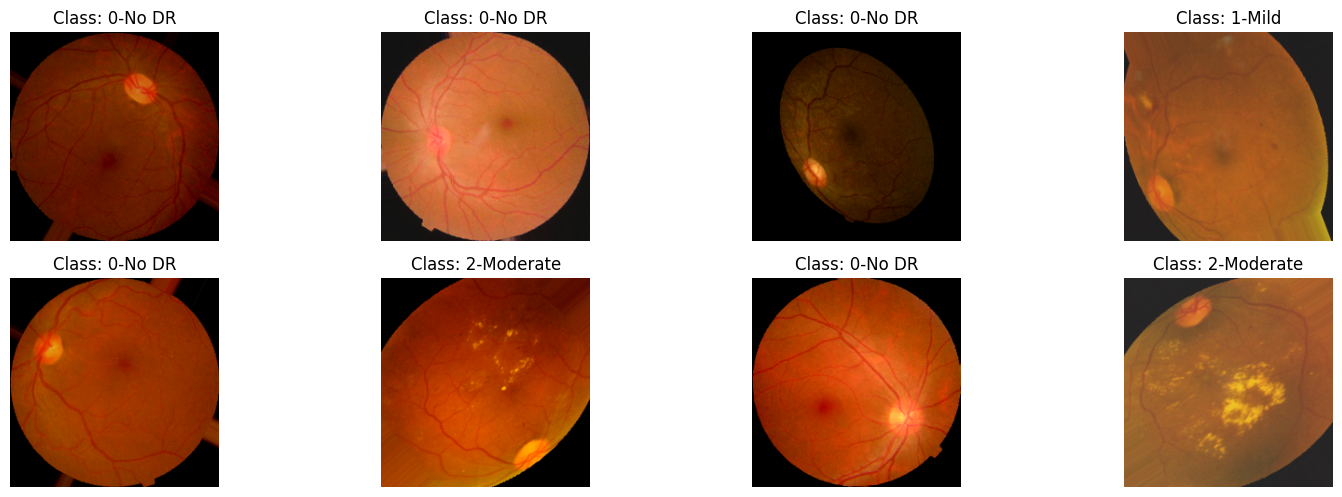


Displaying preprocessed validation images:


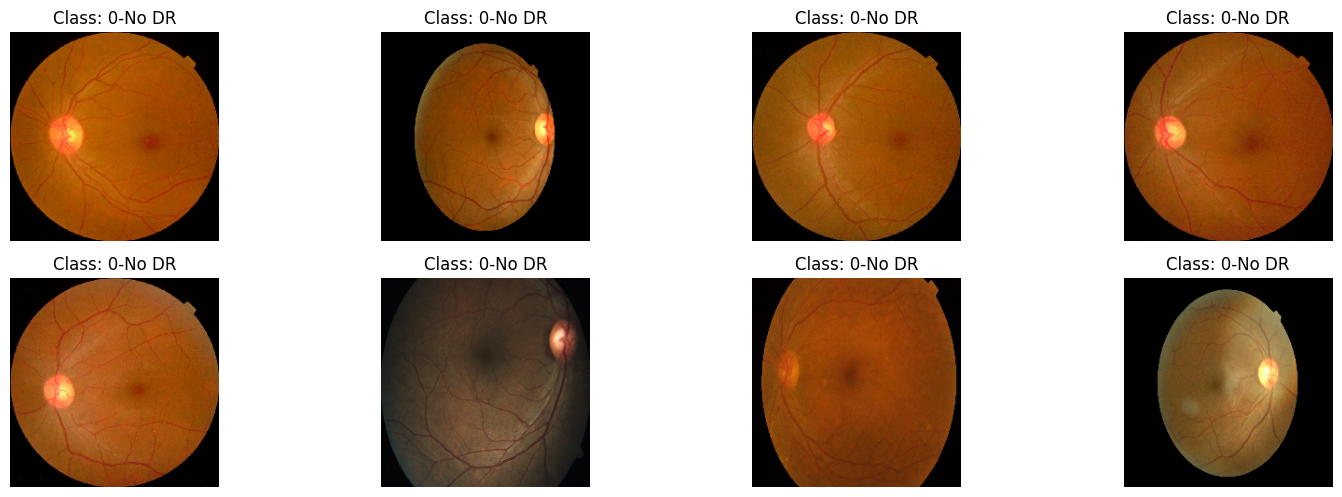


Displaying preprocessed test images:


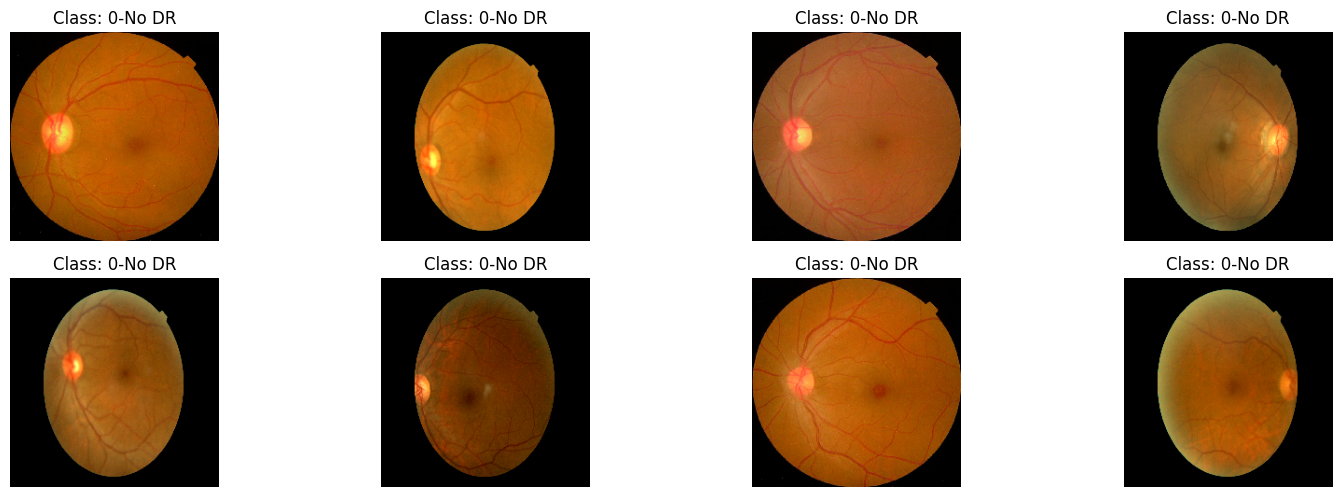

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def display_images(generator, num_images=8):
    # Get a batch of images
    images, labels = next(generator)
    
    # Get class names from the generator
    class_names = list(generator.class_indices.keys())
    
    # Create a figure
    plt.figure(figsize=(15, 10))
    
    # Display images
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i+1)  # Create a 4x4 grid for displaying images
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")  # Get the class name from the labels
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display preprocessed training images
print("Displaying preprocessed training images:")
display_images(train_generator, num_images=8)

# Display preprocessed validation images
print("\nDisplaying preprocessed validation images:")
display_images(validation_generator, num_images=8)

# Display preprocessed test images
print("\nDisplaying preprocessed test images:")
display_images(test_generator, num_images=8)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

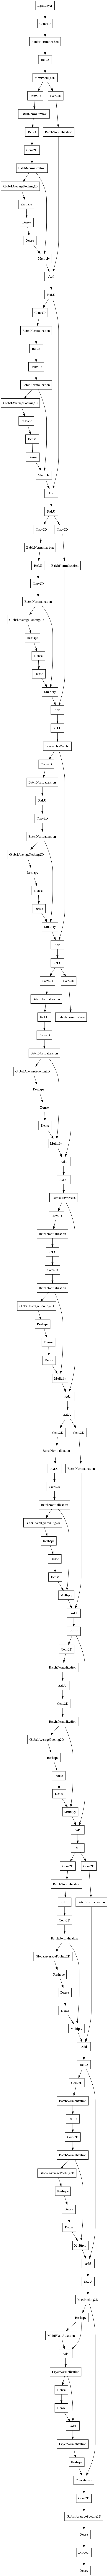

In [ ]:

class LearnableWavelet(tf.keras.layers.Layer):
    def __init__(self, filters, wavelet='haar', **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.wavelet = wavelet
        self.conv_low = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.conv_high = tf.keras.layers.Conv2D(filters, 3, padding='same')

    def call(self, x):
        x_low = self.conv_low(x)  
        x_high = x - x_low       
        x_high = self.conv_high(x_high)
        return x_low + x_high  

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "wavelet": self.wavelet
        })
        return config
def SEBlock(input_tensor, reduction=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    x = Multiply()([input_tensor, se])
    return x

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False, regularizer=l2(0.001)):
    shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size, strides=1, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)
    
    if downsample:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                          kernel_initializer='he_normal',
                          kernel_regularizer=regularizer)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = SEBlock(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x
def build_advanced_model(input_shape=(224, 224, 3), num_classes=4, regularizer=l2(0.001)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=7, strides=2, padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=regularizer)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters_sequence = [int(64 * (1.5**i)) for i in range(5)]  # [64, 96, 144, 216, 324]
    strides_sequence = [1, 1, 2, 1, 2]  
    
    for i in range(5):
        x = residual_block(x, 
                         filters=filters_sequence[i],
                         stride=strides_sequence[i],
                         downsample=True,
                         regularizer=regularizer)
        
        if i in [1, 2]: 
            x = LearnableWavelet(filters=filters_sequence[i])(x)
            
        x = residual_block(x,
                         filters=filters_sequence[i],
                         stride=1,
                         downsample=False,
                         regularizer=regularizer)

    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)  


    x_shape = K.int_shape(x)
    seq_len = x_shape[1] * x_shape[2]
    embed_dim = x_shape[3]
    original_features = x  

    mha_input = Reshape((seq_len, embed_dim))(x)
    attn_output = MultiHeadAttention(
        num_heads=8,  
        key_dim=embed_dim // 8, 
        dropout=0.15 
    )(mha_input, mha_input)
    attn_output = Add()([attn_output, mha_input])
    attn_output = LayerNormalization()(attn_output)

    ffn_output = Dense(embed_dim * 4, activation='gelu')(attn_output) 
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Add()([ffn_output, attn_output])
    ffn_output = LayerNormalization()(ffn_output)

    attn_reshaped = Reshape((x_shape[1], x_shape[2], embed_dim))(ffn_output)
    x = Concatenate()([original_features, attn_reshaped])  
    x = Conv2D(embed_dim, kernel_size=1, kernel_regularizer=regularizer)(x) 


    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', 
              kernel_initializer='he_normal', 
              kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x) 
    outputs = Dense(num_classes, activation=None, 
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizer)(x)
    
    model = Model(inputs, outputs)
    return model
# class_counts = [1635, 331, 1065, 264]
#class_counts = [1635, 331, 891, 438]
class_counts = [1456, 295, 589, 396]
num_classes = len(class_counts)  
model = build_advanced_model(input_shape=(224, 224, 3), num_classes=num_classes)
model.summary()


class BalancedSoftmaxLoss(tf.keras.losses.Loss):
    def __init__(self, class_counts, name='balanced_softmax_loss', **kwargs):
        super(BalancedSoftmaxLoss, self).__init__(name=name, **kwargs)
        self.class_counts = tf.constant(class_counts, dtype=tf.float32)

    def call(self, y_true, logits):
        y_true_converted = tf.cond(
            tf.equal(tf.rank(y_true), 2),
            lambda: tf.argmax(y_true, axis=-1),
            lambda: tf.cast(y_true, tf.int64)
        )
        adjusted_logits = logits + tf.math.log(self.class_counts)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_converted, logits=adjusted_logits)
        return loss

    def get_config(self):
        config = super(BalancedSoftmaxLoss, self).get_config()
        config.update({"class_counts": self.class_counts.numpy().tolist()})
        return config

model.compile(optimizer=Adam(learning_rate=0.0002),
              loss=BalancedSoftmaxLoss(class_counts=class_counts),
              metrics=['accuracy'])

from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=False,show_layer_names=False)

In [5]:
# module8 Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5, 
                              patience=3,  
                              min_lr=0.00000002,
                              mode='min',
                              verbose=1 )

checkpoint = ModelCheckpoint('model_best.h5',  
                             monitor='val_loss',
                             save_best_only=True, 
                             mode='min') 

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min',
                               restore_best_weights=True) 

history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    epochs=150,  
    callbacks=[checkpoint, early_stopping, reduce_lr],
    workers=6, 
    max_queue_size=20
)



Epoch 1/150
92/92 [==============================] - 58s 489ms/step - loss: 11.1362 - accuracy: 0.4496 - val_loss: 10.9679 - val_accuracy: 0.2698 - lr: 2.0000e-04
Epoch 2/150
92/92 [==============================] - 46s 470ms/step - loss: 10.4263 - accuracy: 0.5845 - val_loss: 11.4305 - val_accuracy: 0.1090 - lr: 2.0000e-04
Epoch 3/150
92/92 [==============================] - 46s 476ms/step - loss: 9.8753 - accuracy: 0.6077 - val_loss: 10.7267 - val_accuracy: 0.1608 - lr: 2.0000e-04
Epoch 4/150
92/92 [==============================] - 47s 477ms/step - loss: 9.3067 - accuracy: 0.6309 - val_loss: 9.3185 - val_accuracy: 0.1253 - lr: 2.0000e-04
Epoch 5/150
92/92 [==============================] - 46s 469ms/step - loss: 8.7490 - accuracy: 0.6320 - val_loss: 8.5509 - val_accuracy: 0.5722 - lr: 2.0000e-04
Epoch 6/150
92/92 [==============================] - 46s 466ms/step - loss: 8.2169 - accuracy: 0.6374 - val_loss: 7.8593 - val_accuracy: 0.7003 - lr: 2.0000e-04
Epoch 7/150
92/92 [==========

In [6]:
# module10 Load the best model 
model = load_model('model_best.h5', custom_objects={'BalancedSoftmaxLoss': BalancedSoftmaxLoss,'LearnableWavelet': LearnableWavelet})

In [7]:
# Model Evaluation

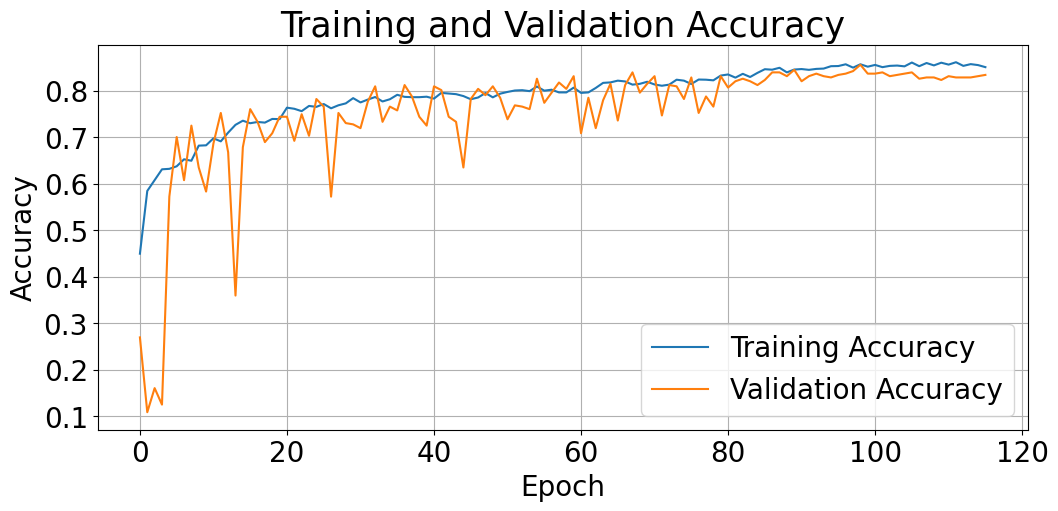

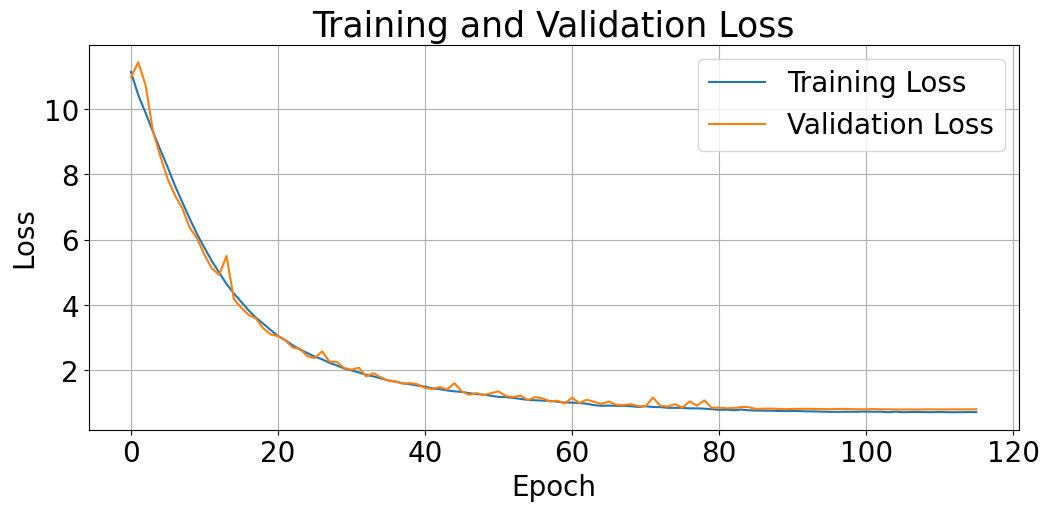

In [8]:
save_dir='plots'
if not os.path.exists(save_dir): 
    os.mkdir(save_dir)

plt.figure(figsize=(12, 5))
# Accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'), dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 5))
# Loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=25)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'loss_plot.png'), dpi=600, bbox_inches='tight')
plt.show()

In [9]:
# Prediction and Inference

In [10]:
# Make predictions on the test data
predictions = model.predict(test_generator)  
true_labels = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  
predicted_classes = np.argmax(predictions, axis=1)

12/12 [==============================] - 20s 2s/step


In [11]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

def evaluate_model(true_labels, predicted_classes, class_labels, save_dir):
    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Micro average accuracy
    micro_accuracy = accuracy_score(true_labels, predicted_classes)
    
    # Generate classification report
    classification_report_dict = classification_report(
        true_labels, predicted_classes, target_names=class_labels, output_dict=True, zero_division=0
    )

    # Calculate specificity and accuracy per class
    specificity_per_class = []
    accuracy_per_class = []
    total_tn, total_fp = 0, 0  # For micro-average specificity
    for i in range(len(class_labels)):
        true_negative = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0.0
        specificity_per_class.append(specificity)

        accuracy = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0.0
        accuracy_per_class.append(accuracy)

        total_tn += true_negative
        total_fp += false_positive

    # Calculate macro and micro average specificity
    macro_specificity = np.mean(specificity_per_class)
    micro_specificity = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0.0

    # Save classification report as JSON
    json_save_path = os.path.join(save_dir, "classification_report.json")
    with open(json_save_path, "w") as f:
        json.dump(classification_report_dict, f, indent=4)
    print(f"Classification Report saved to {json_save_path}")

    # Print classification report
    print("Classification Report:")
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Specificity':<12} {'Accuracy':<12} {'Support':<12}")
    for idx, cls in enumerate(class_labels):
        metrics = classification_report_dict[cls]
        print(f"{cls:<20} {metrics['precision']:<12.2f} {metrics['recall']:<12.2f} {metrics['f1-score']:<12.2f} {specificity_per_class[idx]:<12.2f} {accuracy_per_class[idx]:<12.2f} {metrics['support']:<12}")

    # Calculate macro average accuracy
    macro_accuracy = np.mean(accuracy_per_class)

    # Print micro average accuracy
    print(f"\nMicro Average Accuracy: {micro_accuracy:.2f}")
    
    # Print macro average accuracy
    print(f"Macro Average Accuracy: {macro_accuracy:.2f}")

    # Macro and Micro average metrics
    macro_precision = precision_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_recall = recall_score(true_labels, predicted_classes, average='macro', zero_division=0)
    macro_f1 = f1_score(true_labels, predicted_classes, average='macro', zero_division=0)

    micro_precision = precision_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_recall = recall_score(true_labels, predicted_classes, average='micro', zero_division=0)
    micro_f1 = f1_score(true_labels, predicted_classes, average='micro', zero_division=0)

    print("\nMacro Average Metrics:")
    print(f"Precision: {macro_precision:.2f}, Recall: {macro_recall:.2f}, F1-Score: {macro_f1:.2f}, Specificity: {macro_specificity:.2f}")

    print("\nMicro Average Metrics:")
    print(f"Precision: {micro_precision:.2f}, Recall: {micro_recall:.2f}, F1-Score: {micro_f1:.2f}, Specificity: {micro_specificity:.2f}")

evaluate_model(true_labels, predicted_classes, class_labels, save_dir)


Classification Report saved to plots\classification_report.json
Classification Report:
Class                Precision    Recall       F1-Score     Specificity  Accuracy     Support     
0-No DR              0.98         0.95         0.97         0.98         0.95         180.0       
1-Mild               0.62         0.82         0.71         0.94         0.82         40.0        
2-Moderate           0.87         0.75         0.81         0.96         0.75         101.0       
3-4-Severe           0.71         0.82         0.76         0.95         0.82         45.0        

Micro Average Accuracy: 0.87
Macro Average Accuracy: 0.84

Macro Average Metrics:
Precision: 0.80, Recall: 0.84, F1-Score: 0.81, Specificity: 0.96

Micro Average Metrics:
Precision: 0.87, Recall: 0.87, F1-Score: 0.87, Specificity: 0.96


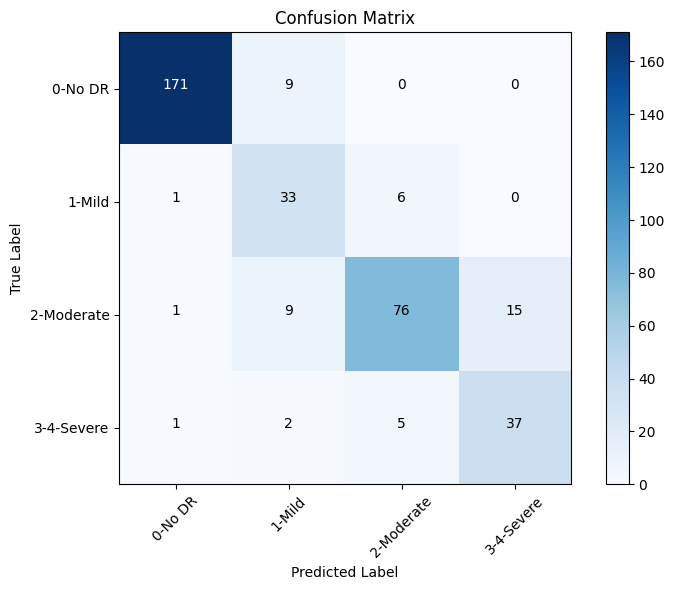

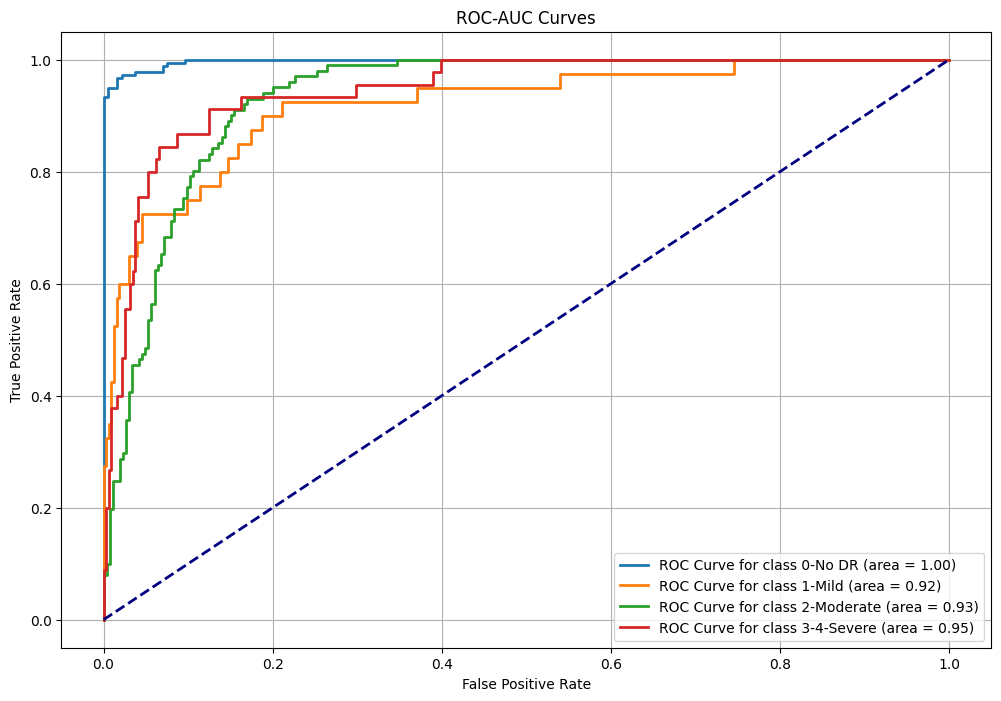

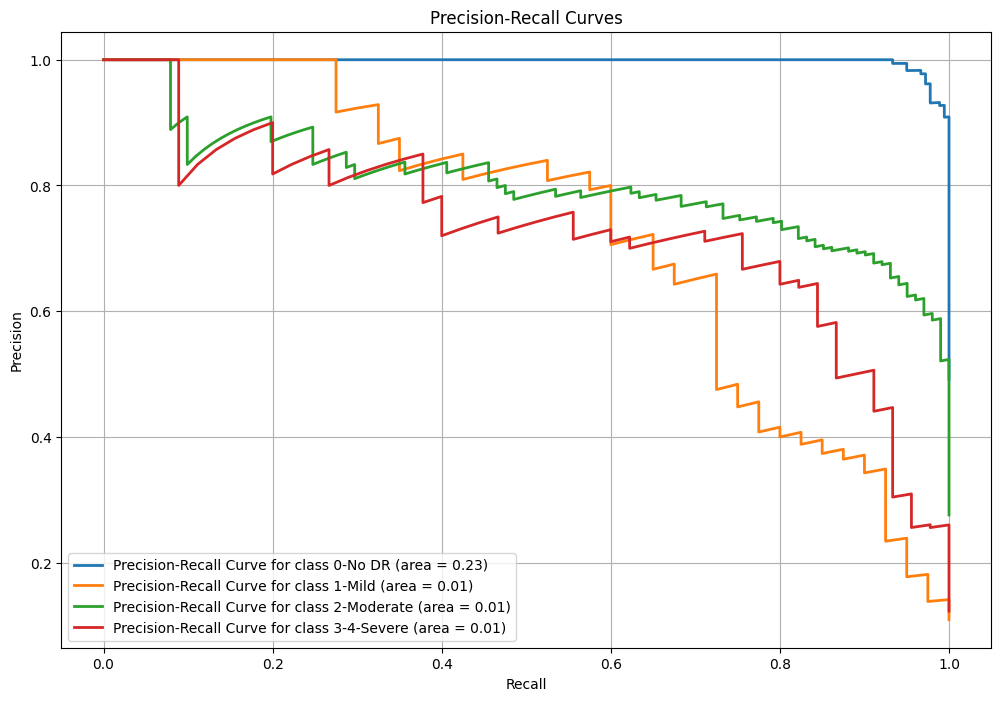

In [12]:
#Confusion Matrix
def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', cmap=plt.cm.Blues, save_dir=None):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/confusion_matrix.png", dpi=600, bbox_inches='tight')
    plt.show()

# ROC-AUC 
def plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(binarized_labels[:, i], predictions[:, i])
        roc_auc = roc_auc_score(binarized_labels[:, i], predictions[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC Curve for class {class_labels[i]} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'roc_auc_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

# Precision-Recall
def plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir):
    binarized_labels = tf.keras.utils.to_categorical(true_labels, num_classes=len(class_labels))
    plt.figure(figsize=(12, 8))
    for i in range(len(class_labels)):
        precision, recall, _ = precision_recall_curve(binarized_labels[:, i], predictions[:, i])
        pr_auc = tf.keras.metrics.AUC()(tf.convert_to_tensor(recall, dtype=tf.float32), tf.convert_to_tensor(precision, dtype=tf.float32)).numpy()
        plt.plot(recall, precision, lw=2, label=f'Precision-Recall Curve for class {class_labels[i]} (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='lower left')
    plt.grid(True)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, 'precision_recall_curve.png'), dpi=600, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', save_dir=save_dir)
plot_roc_auc_curves(true_labels, predictions, class_labels, save_dir)
plot_precision_recall_curves(true_labels, predictions, class_labels, save_dir)

In [13]:
#lime

100%|██████████| 1000/1000 [00:11<00:00, 89.44it/s]


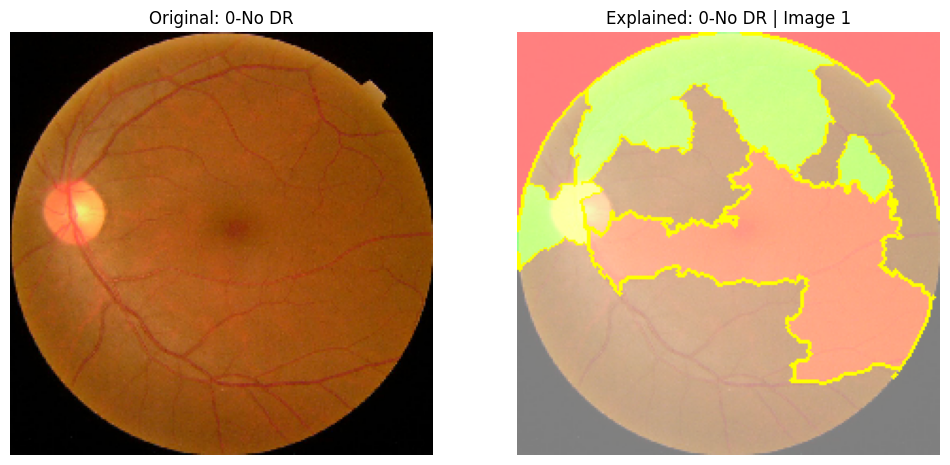

100%|██████████| 1000/1000 [00:10<00:00, 91.60it/s]


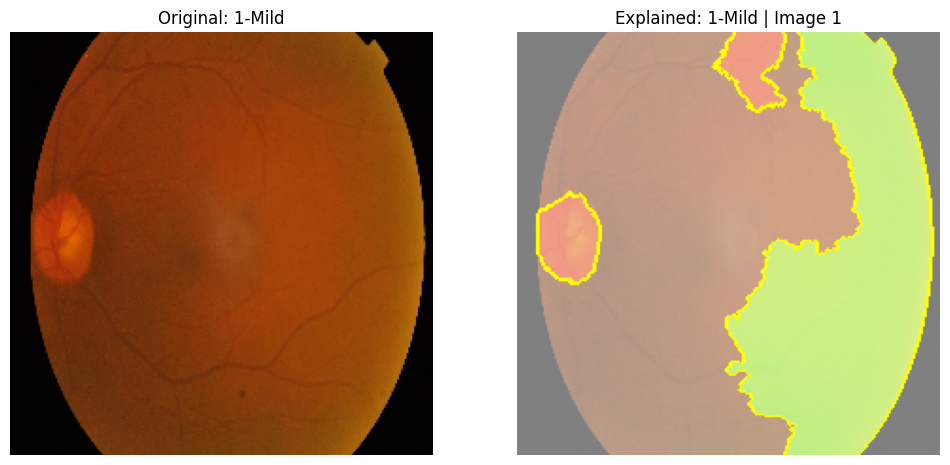

100%|██████████| 1000/1000 [00:10<00:00, 93.72it/s]


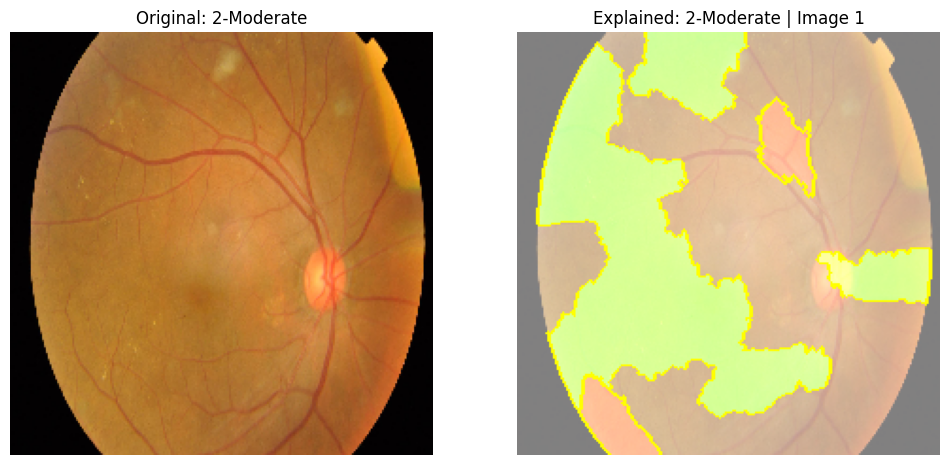

100%|██████████| 1000/1000 [00:10<00:00, 95.38it/s]


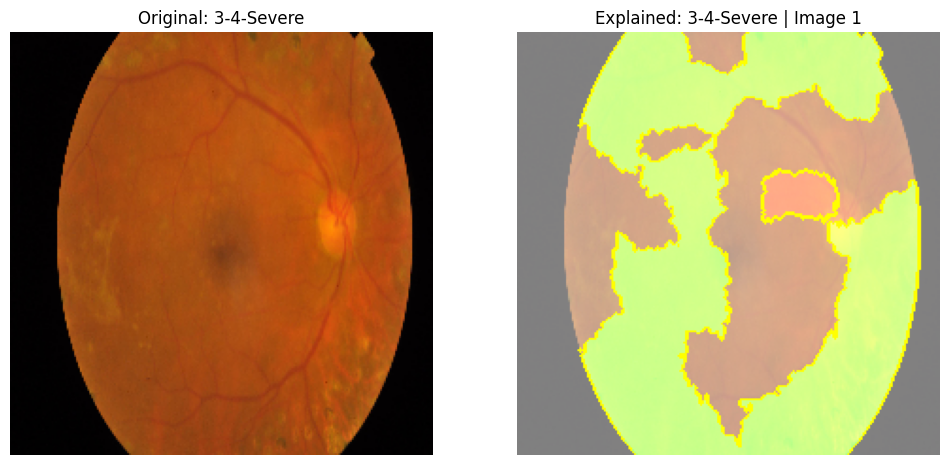

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from contextlib import redirect_stdout
import sys

# Define LIME explainer
explainer = lime_image.LimeImageExplainer()

def model_predict(image_batch):
    """Wrapper function for model prediction."""
    return model.predict(image_batch, verbose=0)  # Disable verbose output

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

num_images = 1  # Number of images to generate explanation for
class_images = {label: [] for label in class_labels}

# Collect images from the test generator
for images, labels in test_generator:
    for i, label in enumerate(labels):
        label_index = np.argmax(label)
        class_name = class_labels[label_index]
        if len(class_images[class_name]) < num_images:
            class_images[class_name].append(images[i])
    if all(len(class_images[label]) >= num_images for label in class_labels):
        break  # Stop once we have at least one image per class

# Create directory for saving plots if it doesn't exist
save_dir = "plots/lime"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def save_lime_explanation(image, class_name, idx):
    """Function to generate and save LIME explanation plots."""
    # Generate explanation
    explanation = explainer.explain_instance(
        image.astype('double'),
        model_predict,
        top_labels=1,
        num_samples=1000
    )

    # Get the mask and explanation image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10
    )

    # Plot and save
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image) 
    plt.title(f"Original: {class_name}")
    plt.axis('off')
    
    # LIME explanation
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f"Explained: {class_name} | Image {idx + 1}")
    plt.axis('off')
    
    # Save plot to file
    save_path = os.path.join(save_dir, f"{class_name}_image.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Suppress output, including progress bars
with open(os.devnull, 'w') as fnull:
    with redirect_stdout(fnull):
        for class_name, images in class_images.items():
            for idx, img in enumerate(images):
                save_lime_explanation(img, class_name, idx)


In [15]:
#gradcam

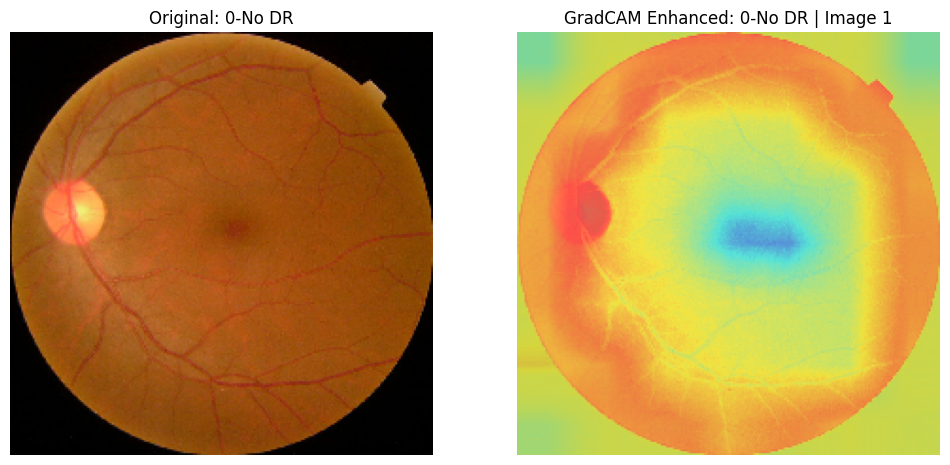

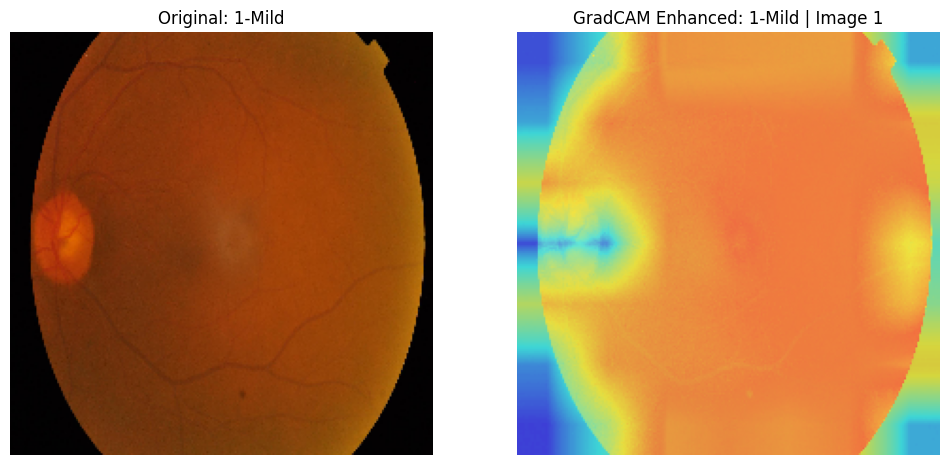

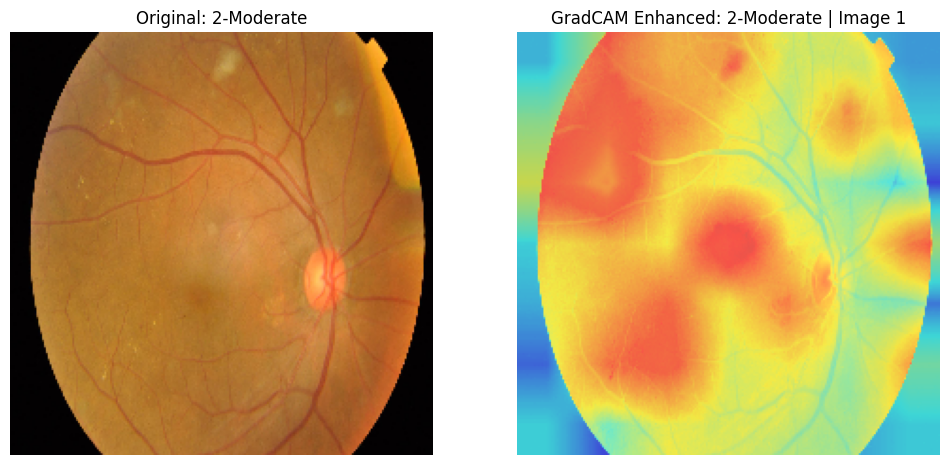

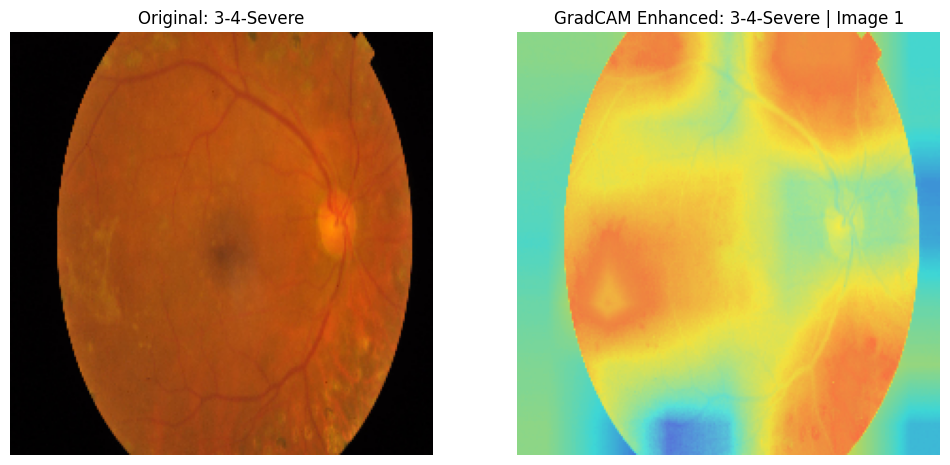

In [16]:
save_dir = "plots/grad_cam"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

target_layer_name = [layer.name for layer in model.layers if 'conv2d' in layer.name][-1]
grad_cam = GradCAM()

for class_name, images in class_images.items():
    label_index = test_generator.class_indices[class_name]
    for idx, img in enumerate(images):
        data = ([img], None) 
        cam_result = grad_cam.explain(
            data, model, class_index=label_index, layer_name=target_layer_name
        )

        cam_result = cam_result - np.min(cam_result) 
        cam_result = cam_result / (np.max(cam_result) + 1e-8)  
        cam_result = (cam_result * 255).astype(np.uint8) 

        heatmap = cv2.applyColorMap(cam_result, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  

        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Original: {class_name}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img, alpha=0.4)  
        plt.imshow(heatmap, alpha=0.6) 
        plt.title(f"GradCAM Enhanced: {class_name} | Image {idx + 1}")
        plt.axis('off')

        save_path = os.path.join(save_dir, f"{class_name}_image.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()



In [17]:
#shap

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


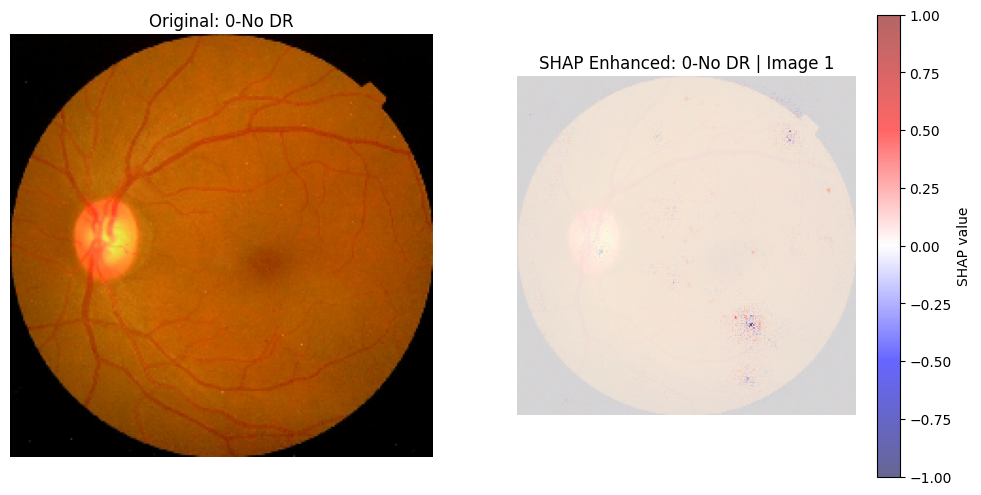

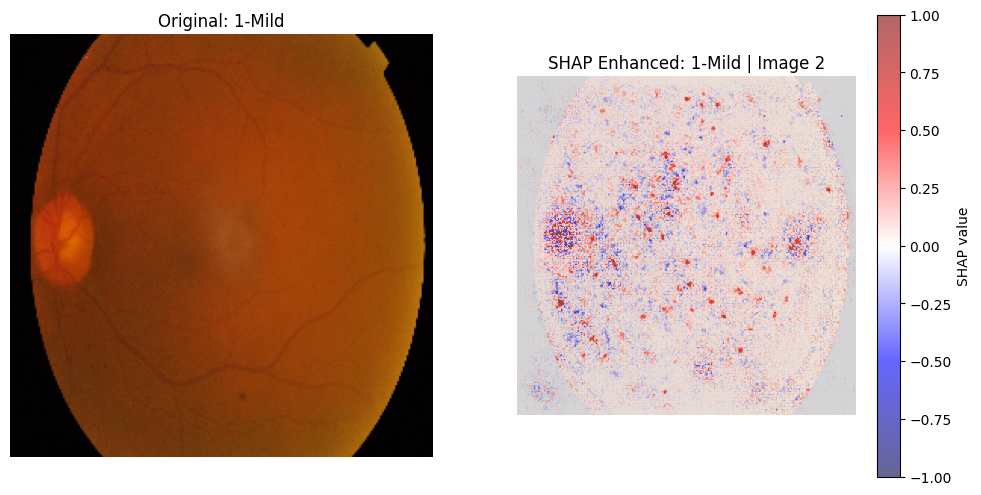

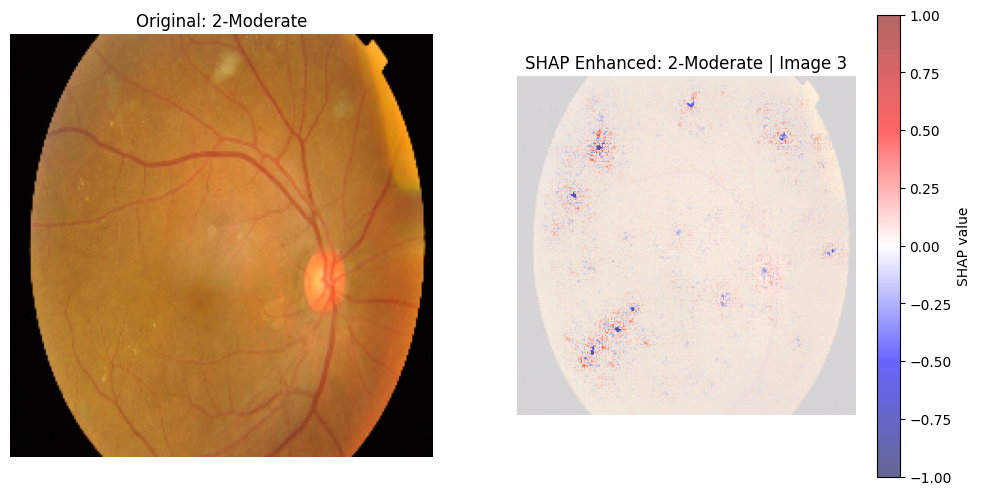

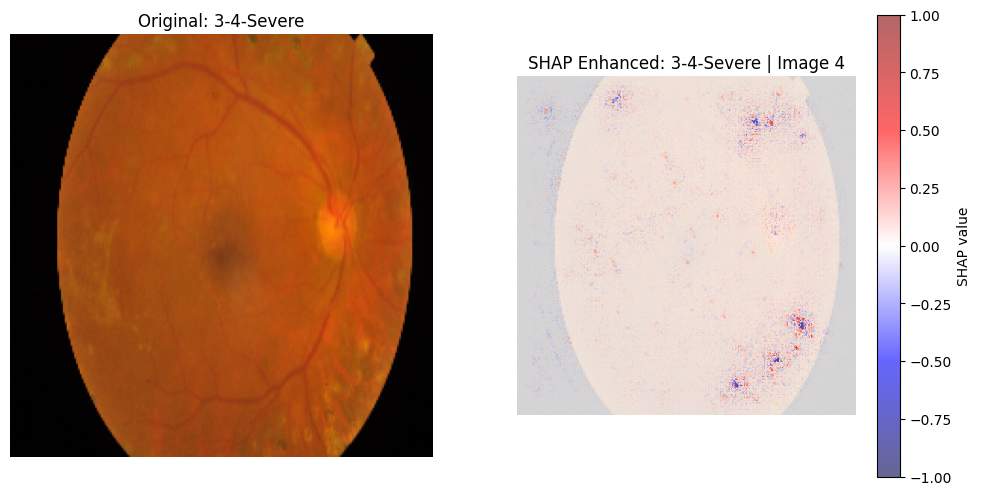

In [18]:
import shap
import matplotlib.pyplot as plt
import os
import numpy as np

# Preprocessing function (same as before)
def preprocess_image(image):
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    crop_size = min(center_x, center_y)
    cropped_image = image[center_y - crop_size:center_y + crop_size,
                          center_x - crop_size:center_x + crop_size]

    resized_image = cv2.resize(cropped_image, (224, 224))
    normalized_image = resized_image / 255.0  # Normalizing
    return normalized_image

# Create save directory for SHAP plots
save_dir = "plots/shap"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load data
background_data = next(iter(test_generator))[0][:50]  # Load some background data for SHAP
explainer = shap.GradientExplainer(model, background_data)

# Dictionary to store one image per class
class_images = {class_name: None for class_name in test_generator.class_indices}

# Select one image for each class
for images, labels in test_generator:
    for i, label in enumerate(labels):
        label_index = np.argmax(label)
        class_name = [k for k, v in test_generator.class_indices.items() if v == label_index][0]

        if class_images[class_name] is None:  # Only pick the first image for each class
            class_images[class_name] = images[i]

    # Stop once we have one image for each class
    if all(image is not None for image in class_images.values()):
        break

# Now we can compute SHAP values for the selected images
def plot_shap_values(image, shap_values, save_path, class_name, idx):
    """ 绘制增强版 SHAP 解释结果 """
    shap_values = np.array(shap_values) 
    shap_values = np.mean(shap_values, axis=-1)  # Reduce dimensions if needed
    abs_max = np.max(np.abs(shap_values))
    if abs_max > 0:
        shap_values /= abs_max
    shap_values *= 3

    plt.figure(figsize=(12, 6))
    
    # Original image subplot
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original: {class_name}")
    plt.axis('off')
    
    # SHAP enhanced image subplot
    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.4)  # Overlay with alpha transparency
    plt.imshow(shap_values, cmap="seismic", alpha=0.6, vmin=-1, vmax=1)  # SHAP values overlay
    plt.colorbar(label="SHAP value")
    plt.title(f"SHAP Enhanced: {class_name} | Image {idx + 1}")
    plt.axis('off')

    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Loop through the selected images and compute SHAP
for idx, (class_name, img) in enumerate(class_images.items()):
    # Compute SHAP values for the selected image (add batch dimension)
    shap_values = explainer.shap_values(img[np.newaxis, ...])  # SHAP expects a batch dimension

    # Save the SHAP plot
    save_path = os.path.join(save_dir, f"{class_name}_image.png")
    plot_shap_values(img, shap_values[0][0], save_path, class_name, idx)
